# 演習問題2
## Cntextial Inquiry法にWord2Vecを用いる

社会人講座第3回で作成したシナリオから分散表現を獲得し，スケジュール管理における不便さやストレスを探り，ITツールを活用してより効率的かつ正確に予定を管理する方法を見つける．

In [1]:
import pandas as pd
import numpy as np
import MeCab
import ipadic
import re
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib import rcParams

#rcParamsに文字化けしないようにフォントの設定を行う
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Hiragino Maru Gothic Pro', 'Yu Gothic', 'Meirio', 'Takao', 'IPAexGothic', 'IPAPGothic', 'VL PGothic', 'Noto Sans CJK JP']


In [2]:
# 形態素解析器の初期化
tagger = MeCab.Tagger(ipadic.MECAB_ARGS)
tagger.parse("")  # MeCabの初期化（空文字列を解析することで初期化）

'EOS\n'

### ストップワードの改良

In [3]:
# 追加のストップワードを設定
additionel_stopwords = ["a", "いる", "か月", "する", "ユーザ"]

# ストップワードの読み込み
with open("stop_words.txt", encoding="utf-8") as f:
    stop_words = set(line.strip().lower() for line in f if line.strip())

# ストップワードを追加
stop_words.update(map(str.lower, additionel_stopwords))

### トークナイズにおける問題点

辞書によってはトークナイズの際におかしな分け方をしてしまう<br>
例：スマホ⇒[スマ, ホ]

In [4]:
parsed = tagger.parse("メモを取る際、スマホを使う")
print(parsed)

メモ	名詞,サ変接続,*,*,*,*,メモ,メモ,メモ
を	助詞,格助詞,一般,*,*,*,を,ヲ,ヲ
取る	動詞,自立,*,*,五段・ラ行,基本形,取る,トル,トル
際	名詞,非自立,副詞可能,*,*,*,際,サイ,サイ
、	記号,読点,*,*,*,*,、,、,、
スマ	名詞,固有名詞,一般,*,*,*,スマ,スマ,スマ
ホ	名詞,一般,*,*,*,*,ホ,ホ,ホ
を	助詞,格助詞,一般,*,*,*,を,ヲ,ヲ
使う	動詞,自立,*,*,五段・ワ行促音便,基本形,使う,ツカウ,ツカウ
EOS



カタカナ語が連続する場合，連結するようにトークナイズする

In [ ]:
# 英数字・記号などの正規化関数
def clean_token(surface):
    surface = surface.lower()
    surface = re.sub(r'[0-9０-９一二三四五六七八九十百千万億兆]+', '', surface)
    surface = re.sub(r'[^\wぁ-んァ-ン一-龥ー]+', '', surface)
    return surface

# トークナイズ＋カタカナ語の連結
def tokenize_clean(text):
    node = tagger.parseToNode(text)
    tokens = []
    buffer = ""  # カタカナ連続語用バッファ

    while node:
        surface = node.surface
        features = node.feature.split(',')
        pos = features[0]
        base = features[6] if len(features) > 6 and features[6] != '*' else surface
        norm = clean_token(base)

        # カタカナだけで構成されているならバッファに追加
        if re.fullmatch(r'[ァ-ンー]+', surface):
            buffer += surface
        else:
            # カタカナバッファがあればまず吐き出す
            if buffer:
                if buffer.lower() not in stop_words:
                    tokens.append(buffer.lower())
                buffer = ""
            # 通常の単語処理
            if pos in ["名詞", "動詞", "形容詞"] and norm and norm not in stop_words:
                tokens.append(norm)
        node = node.next

    # 最後にバッファを処理
    if buffer and buffer.lower() not in stop_words:
        tokens.append(buffer.lower())

    return tokens


In [6]:
# スマホが[スマ, ホ]に分かれなくなる
print(tokenize_clean("メモを取る際、スマホを使う"))

['メモ', '取る', 'スマホ', '使う']


### コーパスを読み込む
今回は，コーパスに皆様が作成されたシナリオを使用しています．<br>
分析の邪魔にならないように"・"はすべて削除しています．<br>
シナリオに書かれていた名前の部分はすべて"ユーザ"に書き換えています．

In [7]:
# コーパスの読み込み
df = pd.read_csv("./csv/scenario_data.csv")

# トークン化
sentences = df["text"].apply(tokenize_clean)

### 同じ意味を持つ単語を統合
"pc"と"パソコン"など同じ意味を持つ単語を1語に統合することで，単語空間の過剰な分散を防げる

In [8]:
# 意味の同じ単語を1語にまとめるための変換辞書
replace_dict = {
    "pc": "パソコン" # "pc"をすべて"パソコン"に置き換える
}

# 統合関数により単語の並びを変えることなく目的語を変換出来る
def batch_replace(sentences, replace_dict):
    return [
        [replace_dict.get(token, token) for token in sentence]
        for sentence in sentences
    ]

# 変換辞書を適用
sentences = batch_replace(sentences, replace_dict)

### Word2Vecの作成

In [9]:
w2v_model = Word2Vec(
    sentences=sentences, 
    vector_size=100, 
    window=5, 
    min_count=2, 
    sg=1,
    seed=42
    )


In [10]:
print(f"モデルの語彙数：{len(w2v_model.wv)}")

モデルの語彙数：198


In [11]:
# テキストを空白区切りにして渡す
joined_texts = [" ".join(tokens) for tokens in sentences]
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(joined_texts)
feature_names = vectorizer.get_feature_names_out()


In [12]:
# すべてのシナリオのTF-IDF上位単語
for j in range(len(sentences)):
    row = tfidf_matrix[j].toarray().flatten()
    top_indices = row.argsort()[::-1][:5]
    top_words = [feature_names[i] for i in top_indices if feature_names[i] in w2v_model.wv]

    print(f"シナリオ{j}番目のTF-IDF上位語:", top_words)


シナリオ0番目のTF-IDF上位語: ['スケジュール', 'アプリ', '個人', '家族', '管理']
シナリオ1番目のTF-IDF上位語: ['タイムツリー', 'アルバイト', 'すぎる', '予定', '感じる']
シナリオ2番目のTF-IDF上位語: ['予定', 'カレンダー', '追加', 'スマホ', 'なる']
シナリオ3番目のTF-IDF上位語: ['考える', 'アプリ', 'なる', '種類', '登録']
シナリオ4番目のTF-IDF上位語: ['予定', 'グーグルカレンダー', '宿題', '登録', '研究']
シナリオ5番目のTF-IDF上位語: ['られる', '私用', '仕事', '予定', 'outlook']
シナリオ6番目のTF-IDF上位語: ['送信', '予約', 'gmail', '見える', '使う']
シナリオ7番目のTF-IDF上位語: ['予定', 'カレンダーアプリ', 'バイト', '空く', '都度']
シナリオ8番目のTF-IDF上位語: ['予定', '登録', 'れる', '友人', 'カレンダーアプリ']
シナリオ9番目のTF-IDF上位語: ['timetree', '確認', '予定', '時間割', '登録']
シナリオ10番目のTF-IDF上位語: ['app', 'todo', 'カレンダー', '表示', '予定']


In [13]:
# 任意のシナリオのTF-IDF上位単語
scenarioID = 0
row = tfidf_matrix[scenarioID].toarray().flatten()
top_indices = row.argsort()[::-1][:5]
top_words = [feature_names[i] for i in top_indices if feature_names[i] in w2v_model.wv]

print(f"シナリオ{scenarioID}番目のTF-IDF上位語:", top_words)

# 平均ベクトルを求める
word_vecs = [w2v_model.wv[word] for word in top_words]
avg_vec = np.mean(word_vecs, axis=0)

# 周辺語を表示
similar_words = w2v_model.wv.similar_by_vector(avg_vec, topn=10)
print(f"シナリオ{scenarioID}番目の周辺語:")
similar_words

シナリオ0番目のTF-IDF上位語: ['スケジュール', 'アプリ', '個人', '家族', '管理']
シナリオ0番目の周辺語:


[('予定', 0.9945305585861206),
 ('アプリ', 0.9940282106399536),
 ('確認', 0.9928589463233948),
 ('スケジュール', 0.9920971393585205),
 ('なる', 0.9913048148155212),
 ('登録', 0.9903108477592468),
 ('管理', 0.9895949959754944),
 ('ある', 0.9893222451210022),
 ('todo', 0.989001989364624),
 ('研究', 0.98850017786026)]

### 意味マップの画像化
任意の単語とその単語の類似度上位20単語からなる空間をPCAで2次元に圧縮し画像化する

In [14]:
def plot_word_map_pca(center_word, model, topn=20):
    if center_word not in model.wv:
        print(f"{center_word} は語彙にありません。")
        return

    # 類似語取得
    similar_words = model.wv.most_similar(center_word, topn=topn)
    words = [center_word] + [w for w, _ in similar_words]
    vecs = np.array([model.wv[w] for w in words])

    # PCAで2次元に圧縮
    pca = PCA(n_components=2, random_state=42)
    vecs_2d = pca.fit_transform(vecs)

    # プロット
    plt.figure(figsize=(10, 8))
    for i, word in enumerate(words):
        x, y = vecs_2d[i]
        plt.scatter(x, y, color='red' if i == 0 else 'blue')
        plt.text(x, y, word, fontsize=12)
    plt.title(f"PCA: '{center_word}' を中心とした意味マップ")
    plt.grid(True)
    plt.show()


In [15]:
target_word = "スマホ"

[('予定', 0.9781976342201233), ('確認', 0.9776747822761536), ('ある', 0.9748240113258362), ('todo', 0.9744026064872742), ('登録', 0.9738317728042603), ('なる', 0.9734084010124207), ('スマートフォン', 0.9731307625770569), ('画面', 0.97120600938797), ('カレンダー', 0.9704337120056152), ('リマインダー', 0.9702398180961609), ('しまう', 0.9698984026908875), ('れる', 0.9695888161659241), ('表示', 0.9694178700447083), ('スケジュール', 0.9687969088554382), ('内容', 0.968644917011261), ('研究', 0.9685769081115723), ('app', 0.9678955078125), ('時間割', 0.9675558805465698), ('アルバイト', 0.9671309590339661), ('考える', 0.9670926332473755)]


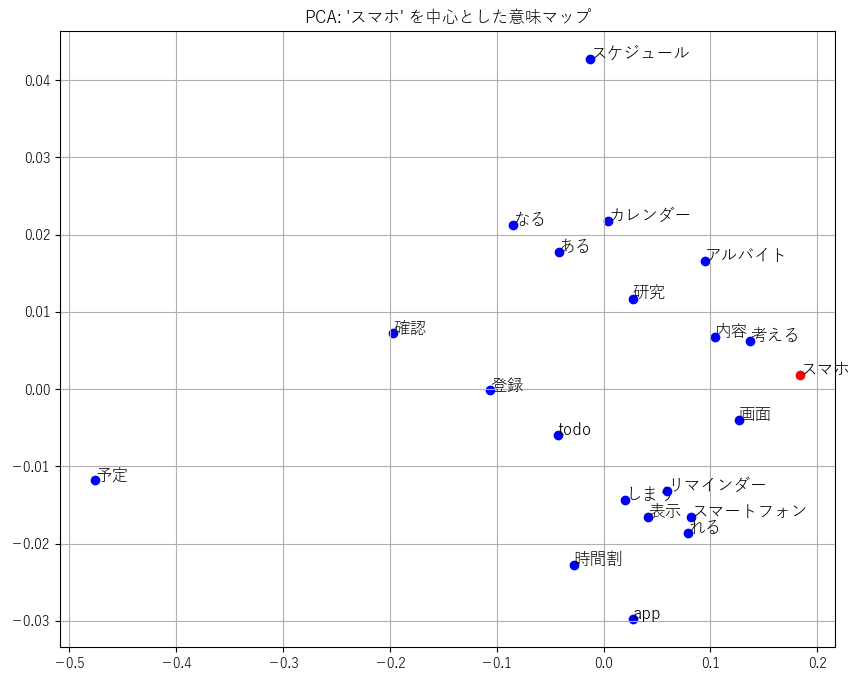

In [16]:
print(w2v_model.wv.most_similar(target_word, topn=20))
plot_word_map_pca(target_word, w2v_model)


### 考察問題1 スマホを中心とした意味マップから本コーパスにおける"スマホ"はどのような使われ方をしているか考察してください

回答例  
[予定, カレンダー, 時間割, リマインダー, スケジュール, todo, 登録]から，スマホが日程管理・リマインド用途に使われる文脈が強い  
[画面, 表示, app, スマートフォン, しまう, れる]から，アプリ操作や表示動作との関係が強調されている  
[考える, ある, なる, 内容, 確認]から，スマホを通して思考や意思決定の支援がなされている可能性が高い

まとめると，スマホが単なる端末というよりも，時間管理・タスク遂行・意思決定支援といった日常・実務の実行基盤として機能している。

## 課題 自分で前処理を設計して得られた結果から考察してください
唯一の正解がないので，TAさんのアドリブ力が試されます．頑張ってください．

### 操作1 ストップワードの改良
`stop_words.txt`を直接書き換えても良い

In [17]:
# 追加のストップワードを設定
additionel_stopwords = []

# ストップワードの読み込み
with open("stop_words.txt", encoding="utf-8") as f:
    stop_words = set(line.strip().lower() for line in f if line.strip())

# ストップワードを追加
stop_words.update(map(str.lower, additionel_stopwords))

### 操作2 同じ意味を持つ単語の統合
"バスケ", "サッカー", "野球"をすべて"スポーツ"に書き換えるという使い方も可能

In [18]:
# 意味の同じ単語を1語にまとめるための変換辞書
replace_dict = {
    
}

# 統合関数により単語の並びを変えることなく目的語を変換出来る
def batch_replace(sentences, replace_dict):
    return [
        [replace_dict.get(token, token) for token in sentence]
        for sentence in sentences
    ]


# トークン化
sentences = df["text"].apply(tokenize_clean)
# 変換辞書を適用
sentences = batch_replace(sentences, replace_dict)

### 操作3 Word2Vecの作成
パラメータを自分で設定してください

In [19]:
model = Word2Vec(
    sentences=sentences, 
    min_count=4
    )

In [20]:
print(f"モデルの語彙数：{len(model.wv)}")

モデルの語彙数：97


### 操作4 今日学んだ内容を振り返り，分析してください

In [21]:
# 任意のシナリオのTF-IDF上位単語
scenarioID = 1
row = tfidf_matrix[scenarioID].toarray().flatten()
top_indices = row.argsort()[::-1][:10]
top_words = [feature_names[i] for i in top_indices if feature_names[i] in model.wv]

print(f"シナリオ{scenarioID}番目のTF-IDF上位語:", top_words)

# 平均ベクトルを求める
word_vecs = [model.wv[word] for word in top_words]
avg_vec = np.mean(word_vecs, axis=0)

# 周辺語を表示
similar_words = model.wv.similar_by_vector(avg_vec, topn=10)
print(f"シナリオ{scenarioID}番目の周辺語:")
similar_words

シナリオ1番目のTF-IDF上位語: ['タイムツリー', 'アルバイト', 'すぎる', '予定', '感じる', '入力', '情報', '通知', '煩わしい']
シナリオ1番目の周辺語:


[('予定', 0.9811313152313232),
 ('いる', 0.9757030010223389),
 ('する', 0.9752071499824524),
 ('感じる', 0.968337893486023),
 ('ユーザ', 0.948047935962677),
 ('登録', 0.9361576437950134),
 ('ある', 0.9321308135986328),
 ('app', 0.9264546036720276),
 ('管理', 0.9204601645469666),
 ('アプリ', 0.9115943312644958)]

In [22]:
# 以下のコードで語彙に含まれるすべての単語を確認できる
# model.wv.index_to_key[:]

[('いる', 0.8315658569335938), ('する', 0.8169166445732117), ('予定', 0.8162545561790466), ('使用', 0.8068305850028992), ('感じる', 0.8061854243278503), ('登録', 0.7866115570068359), ('カレンダー', 0.7852603793144226), ('ある', 0.7825139760971069), ('app', 0.7776415348052979), ('入力', 0.7763594388961792), ('ユーザ', 0.7736499905586243), ('アルバイト', 0.7720029950141907), ('リマインド', 0.7685161232948303), ('づらい', 0.7672224640846252), ('れる', 0.7647854089736938), ('スケジュール', 0.7606063485145569), ('さ', 0.7582477927207947), ('カレンダーアプリ', 0.7574764490127563), ('多い', 0.7565213441848755), ('情報', 0.7558063864707947)]


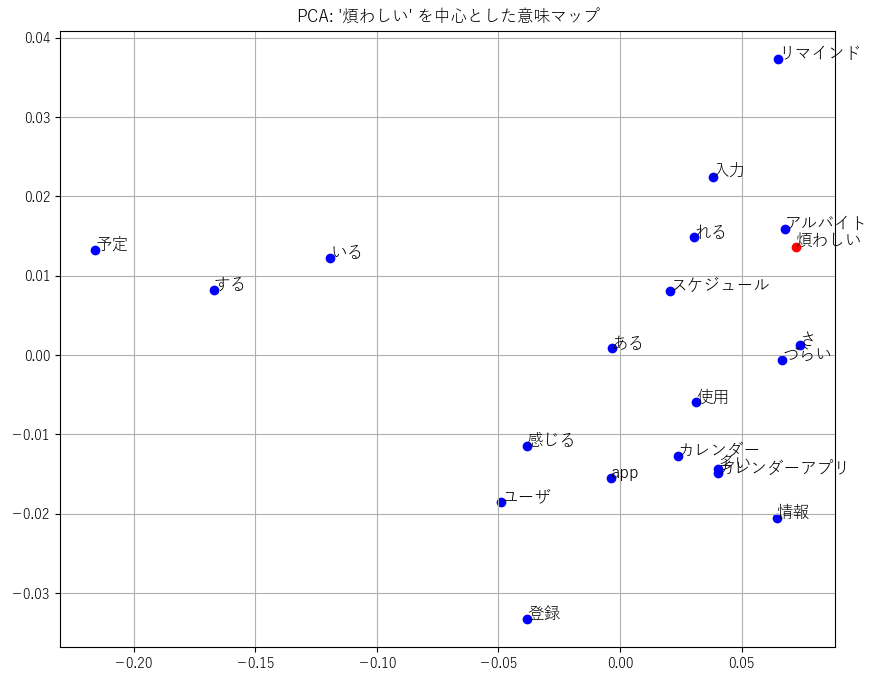

In [23]:
target_word = "煩わしい"
print(model.wv.most_similar(target_word, topn=20))
plot_word_map_pca(target_word, model)

[('いる', 0.6734216809272766), ('使用', 0.6505588889122009), ('登録', 0.646476686000824), ('する', 0.6419910192489624), ('予定', 0.6406328082084656), ('app', 0.6403679847717285), ('ある', 0.6363911032676697), ('高い', 0.6313490867614746), ('ユーザ', 0.6282700300216675), ('表示', 0.6264046430587769), ('感じる', 0.625148355960846), ('入力', 0.6245526075363159), ('多い', 0.6205679178237915), ('覧', 0.61604905128479), ('イベント', 0.6144129037857056), ('場所', 0.6108255386352539), ('重複', 0.6107972860336304), ('カレンダーアプリ', 0.6106483340263367), ('見る', 0.60914146900177), ('管理', 0.6058263778686523)]


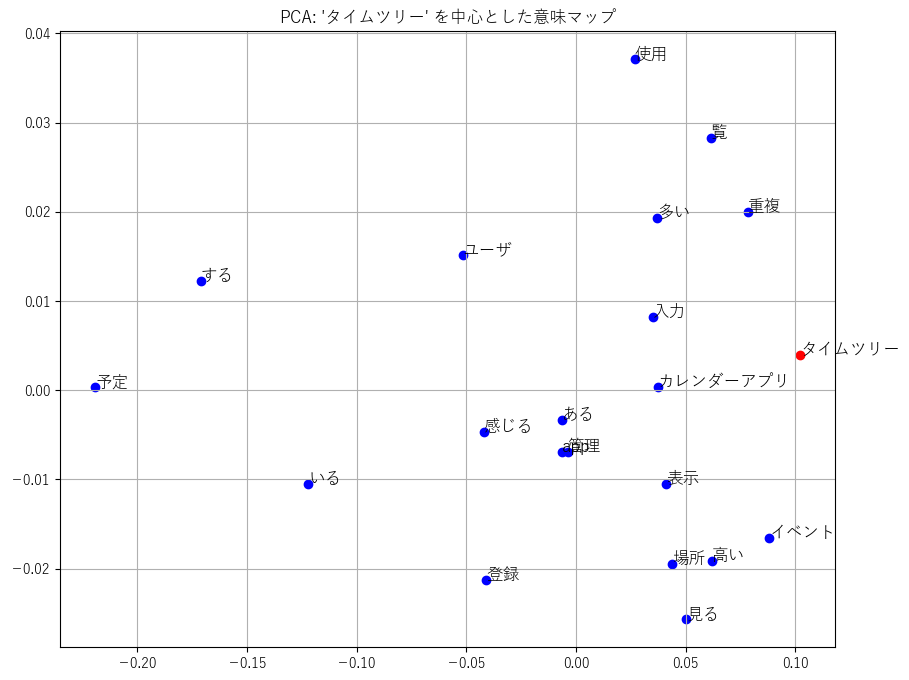

In [24]:
target_word = "タイムツリー"
print(model.wv.most_similar(target_word, topn=20))
plot_word_map_pca(target_word, model)

### 考察問題2 以下の内容で考察してください
社会人講座第3回で作成したシナリオから分散表現を獲得し，スケジュール管理における不便さやストレスを探り，ITツールを活用してより効率的かつ正確に予定を管理する方法を見つける．

<font color = "Red">**TAさんへ**</font>：分析の方針として，"トラブル"や"忘れる"などネガティブな単語からストレスを導き，"カレンダーアプリ"や"グーグルカレンダー"などから有用なITツールを考察してください．重要性の高いと考えられる単語はTF-IDFで見つけてください．前処理によってなくなる単語もあるので柔軟に対応してください．

考察の正しさについて：考察の正解不正解をこの場で確定するのは難しいです．新規スケジュール管理ツールを導入後にもう一度テキストを取得し，単語空間の変化を見ることで評価できます．